# Daily Portfolio Analytics Dashboard

**Boyang Gong**

**Last Updated: October 28, 2025**

Task:
- Set up a new Colab notebook called AnalyticsDashboard.ipynb.
- Use mock or random daily portfolio data for now (just a few hundred points) pull from yFinance
- Build simple charts that show:
  - Cumulative Return vs Drawdown over time — one line for equity growth, another for drawdown depth.
  - Rolling Sharpe vs Volatility — a two-axis plot showing how reward-to-risk changes through time.
  - Distribution of Daily Returns — a histogram that highlights fat tails or high volatility.
  - Add titles, axis labels, and short captions under each chart explaining what it means.
- Save the final figures (PNG or PDF)

Deliverable:
- AnalyticsDashboard.ipynb notebook
- At least 3 exported charts labeled clearly


In [28]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
# Set target folder in Drive
import os
target_dir = "/content/drive/MyDrive/DSGT Project - RoboInvesting/AnalyticsDashboard"
os.makedirs(target_dir, exist_ok=True)  # creates it if it doesn't exist

In [9]:
# Import
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
plt.rcParams['figure.figsize'] = (10, 5)


In [10]:
# Config
TICKER = "AAPL"
START_DATE = "2022-01-01"
END_DATE = None              # None = today
ROLLING_WINDOW = 60          # trading days
ANNUALIZATION = 252          # trading days per year

## yfinance data

In [13]:
if END_DATE is None:
  end_date = pd.Timestamp.today().normalize()
else:
  pd.to_datetime(END_DATE)

yf.download(TICKER, start=START_DATE, end=end_date, progress=False)

/tmp/ipython-input-3604857267.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(TICKER, start=START_DATE, end=end_date, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-01-03,178.443146,179.296107,174.227425,174.345068,104487900
2022-01-04,176.178406,179.354917,175.609770,179.050994,99310400
2022-01-05,171.492065,176.639180,171.217554,176.090157,94537600
2022-01-06,168.629288,171.864620,168.276342,169.315567,96904000
2022-01-07,168.795959,170.727354,167.678301,169.501851,86709100
...,...,...,...,...,...
2025-10-21,262.769989,265.290009,261.829987,261.880005,46695900
2025-10-22,258.450012,262.850006,255.429993,262.649994,45015300


## Daily Returns
Computes simple daily returns via `pct_change()`

In [11]:
# Resolve end date
end_dt = pd.Timestamp.today().normalize() if END_DATE is None else pd.to_datetime(END_DATE)

# yfinance returns a DataFrame
data = yf.download(TICKER, start=START_DATE, end=end_dt, progress=False)

if "Adj Close" in data.columns:
    px = data["Adj Close"].dropna()
else:
    px = data["Close"].dropna()

# Daily returns
returns = px.pct_change().dropna()
returns.name = "daily_return"

print(f"{TICKER}: {returns.index.min().date()} → {returns.index.max().date()} "
      f"({len(returns)} daily obs)")
returns.head()


/tmp/ipython-input-2440073850.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=end_dt, progress=False)


AAPL: 2022-01-04 → 2025-10-27 (957 daily obs)


Ticker,AAPL
Date,
2022-01-04,-0.012692
2022-01-05,-0.026600
2022-01-06,-0.016693
2022-01-07,0.000988
2022-01-10,0.000116


## Equity Curve & Drawdown
- Equity curve: growth of $1 invested.
- Drawdown: drop from the running peak (≤ 0).

In [15]:
equity = (1 + returns).cumprod()
running_max = equity.cummax()
drawdown = (equity / running_max) - 1.0   # <= 0

# Display
equity.tail(), drawdown.tail()

(Ticker          AAPL
 Date                
 2025-10-21  1.472570
 2025-10-22  1.448361
 2025-10-23  1.454693
 2025-10-24  1.472850
 2025-10-27  1.506418,
 Ticker         AAPL
 Date               
 2025-10-21  0.00000
 2025-10-22 -0.01644
 2025-10-23 -0.01214
 2025-10-24  0.00000
 2025-10-27  0.00000)

## Rolling Sharpe & Volatility
- Rolling Sharpe: rolling mean/std × √252.
- Rolling Volatility: rolling std × √252.

In [16]:
rolling_mean = returns.rolling(ROLLING_WINDOW).mean()
rolling_std = returns.rolling(ROLLING_WINDOW).std(ddof=0)
rolling_sharpe = (rolling_mean / rolling_std) * math.sqrt(ANNUALIZATION)
rolling_vol_annual = rolling_std * math.sqrt(ANNUALIZATION)

# Display
rolling_sharpe.tail(), rolling_vol_annual.tail()

(Ticker          AAPL
 Date                
 2025-10-21  3.328702
 2025-10-22  3.263607
 2025-10-23  3.512819
 2025-10-24  3.821271
 2025-10-27  4.634783,
 Ticker          AAPL
 Date                
 2025-10-21  0.271587
 2025-10-22  0.272561
 2025-10-23  0.271016
 2025-10-24  0.270640
 2025-10-27  0.266447)

## Chart 1 — Cumulative Return vs Drawdown
- Left axis: equity (growth of $1).
- Right axis: drawdown (depth below peak).

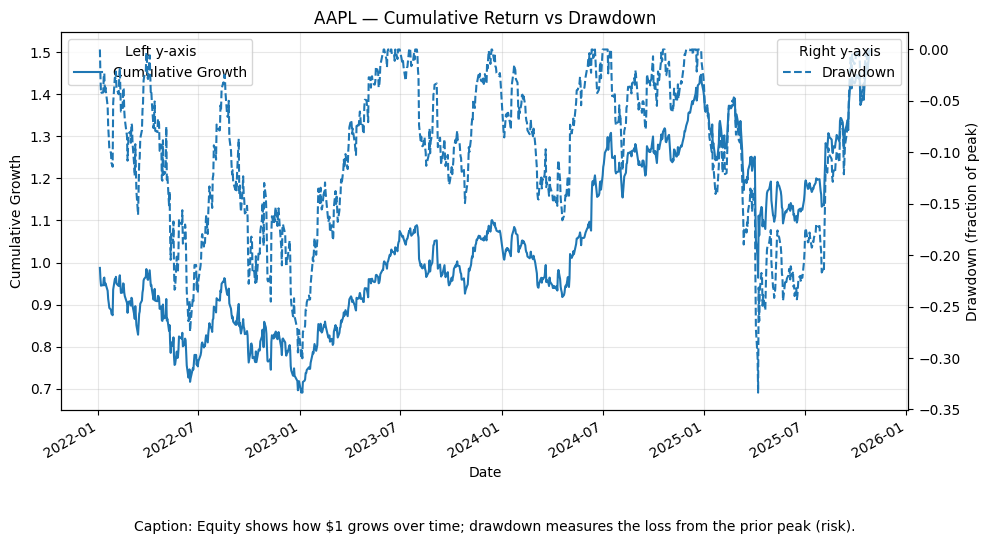

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
# Left y-axis
equity.plot(ax=ax, label="Equity")
ax.set_title(f"{TICKER} — Cumulative Return vs Drawdown")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Growth")
ax.grid(True, alpha=0.3)

# Right y-axis
ax_b = ax.twinx()
drawdown.plot(ax=ax_b, label="Drawdown", linestyle="--")
ax_b.set_ylabel("Drawdown (fraction of peak)")

# Legend
handles_l, labels_l = ax.get_legend_handles_labels()
ax.legend(handles_l, ["Cumulative Growth"],
          loc="upper left", title="Left y-axis")
handles_r, labels_r = ax_b.get_legend_handles_labels()
ax_b.legend(handles_r, ["Drawdown"],
            loc="upper right", title="Right y-axis")

# Plot
plt.figtext(
    0.5, -0.05,
    "Caption: Equity shows how $1 grows over time; drawdown measures the loss from the prior peak (risk).",
    ha="center", va="top"
)

fig.tight_layout()
fig.savefig(os.path.join(target_dir, "chart1_cumulative_vs_drawdown.png"), dpi=150, bbox_inches="tight")
fig.savefig(os.path.join(target_dir, "chart1_cumulative_vs_drawdown.pdf"), bbox_inches="tight")
plt.show()

## Chart 2 — Rolling Sharpe vs Volatility
- Left axis: rolling Sharpe (reward-to-risk).
- Right axis: rolling annualized volatility.

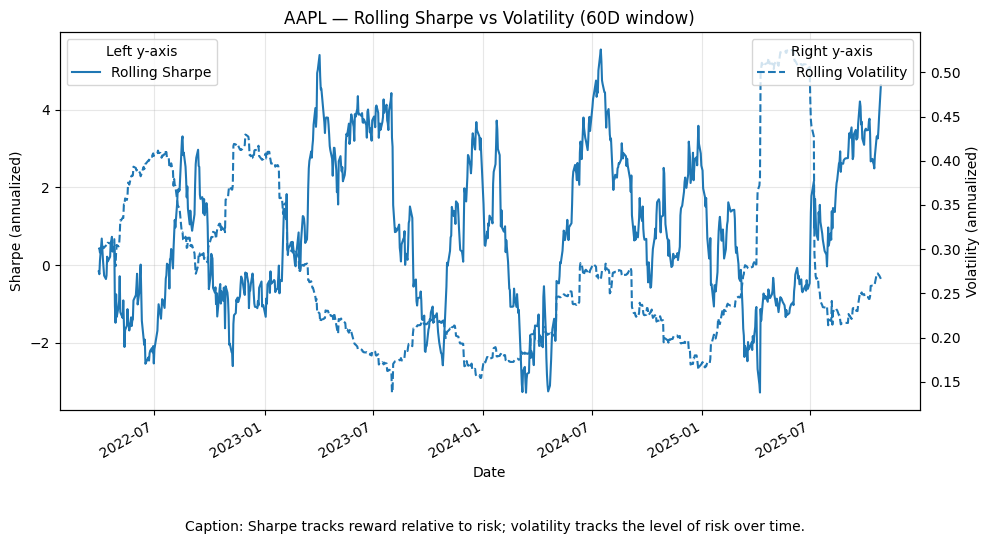

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
# Left y-axis
rolling_sharpe.plot(ax=ax, label="Rolling Sharpe")
ax.set_title(f"{TICKER} — Rolling Sharpe vs Volatility ({ROLLING_WINDOW}D window)")
ax.set_xlabel("Date")
ax.set_ylabel("Sharpe (annualized)")
ax.grid(True, alpha=0.3)

# Right y-axis
ax_b = ax.twinx()
rolling_vol_annual.plot(ax=ax_b, label="Rolling Volatility", linestyle="--")
ax_b.set_ylabel("Volatility (annualized)")

# Legend
handles_l, labels_l = ax.get_legend_handles_labels()
ax.legend(handles_l, ["Rolling Sharpe"],
          loc="upper left", title="Left y-axis")
handles_r, labels_r = ax_b.get_legend_handles_labels()
ax_b.legend(handles_r, ["Rolling Volatility"],
            loc="upper right", title="Right y-axis")

# Plot
plt.figtext(
    0.5, -0.05,
    "Caption: Sharpe tracks reward relative to risk; volatility tracks the level of risk over time.",
    ha="center", va="top"
)

fig.tight_layout()
fig.savefig(os.path.join(target_dir, "chart2_rolling_sharpe_vs_vol.png"), dpi=150, bbox_inches="tight")
fig.savefig(os.path.join(target_dir, "chart2_rolling_sharpe_vs_vol.pdf"), bbox_inches="tight")
plt.show()


## Chart 3 — Distribution of Daily Returns

- A simple histogram to visualize dispersion and tails.

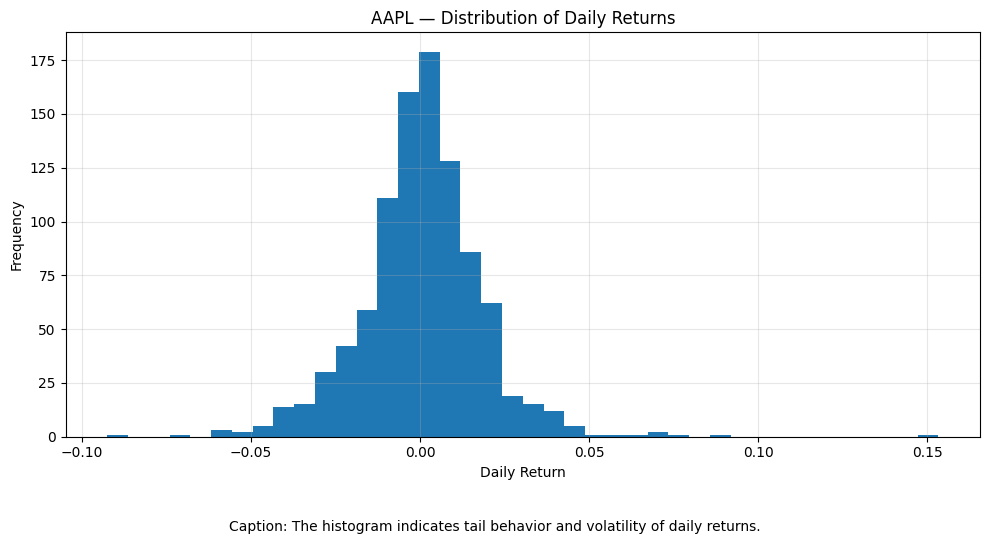

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(returns.values, bins=40)
ax.set_title(f"{TICKER} — Distribution of Daily Returns")
ax.set_xlabel("Daily Return")
ax.set_ylabel("Frequency")
ax.grid(True, alpha=0.3)

plt.figtext(
    0.5, -0.05,
    "Caption: The histogram indicates tail behavior and volatility of daily returns.",
    ha="center", va="top"
)

fig.tight_layout()
fig.savefig(os.path.join(target_dir, "chart3_returns_histogram.png"), dpi=150, bbox_inches="tight")
fig.savefig(os.path.join(target_dir, "chart3_returns_histogram.pdf"), bbox_inches="tight")
plt.show()
